In [1]:
#**Learning Objectives: EMBEDDING**
#* Convert movie-review string data to a sparse feature vector
#* Implement a sentiment-analysis linear model using a sparse feature vector
#* Implement a sentiment-analysis DNN model using an embedding that projects data into two dimensions
#* Visualize the embedding to see what the model has learned about the relationships between words

In [2]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)
#tfrecord
#https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564

In [3]:
def _parse_function(record):#['C:\\Users\\jinlong\\.keras\\datasets\\train.tfrecord']
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']# 'Tensor' object has no attribute 'make_one_shot_iterator'
  print(" {terms:terms}:", {'terms':terms})
  print(" labels:",labels) 
  #n = labels.make_one_shot_iterator().get_next()
  sess = tf.Session()
  #print(" labels:-------") 
  #print("sess.run(labels):",sess.run(labels))
  print("type of terms :",type(terms ))#type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
  print("type of labels:",type(labels))
  print("tf.print labels:------")
  #print("sess.run(labels):",sess.run(labels))
  #tf.Print(labels,[labels])
  #sess.run(tf.Print(labels,[labels]))#
  #InvalidArgumentError: You must feed a value for placeholder tensor 'arg0' with dtype string
  #labels_array=np.array([item['predictions'][0] for item in labels])#Tensor objects are not iterable when eager execution is not enabled.
  print("tf.print------labels-")
  return  {'terms':terms}, labels # return a dict of the features and the corresponding labels.

In [4]:
print(test_path)
print([train_path])
print(test_url.split('/'))
print(test_url.split('/')[-1])

C:\Users\jinlong\.keras\datasets\test.tfrecord
['C:\\Users\\jinlong\\.keras\\datasets\\train.tfrecord']
['https:', '', 'download.mlcc.google.com', 'mledu-datasets', 'sparse-data-embedding', 'test.tfrecord']
test.tfrecord


In [5]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
print("ds:",ds)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)#type of ds: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>

ds
print("type of ds:",type(ds))
# construct a TFRecordDataset for the training data, and map the data to features and labels using the function above.
#sess = tf.Session()
#print("sess.run(ds):",sess.run(ds))#TypeError: Can not convert a MapDataset into a Tensor or Operation.
iterator = ds.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    for i in range(1):
        value = sess.run(next_element)
        print(i, value)
datas=ds.make_one_shot_iterator().get_next()
sess=tf.Session()
print("sess.run(datas):",sess.run(datas))

ds: <TFRecordDataset shapes: (), types: tf.string>
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
type of ds: <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
0 ({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
       b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
       b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
       b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
       b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
       b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
       b'!', b')', b'sascha', b'is', b'played', b'very', b'well', 

In [6]:
#Run the following cell to retrieve the first example from the training data set.
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)
#sess.run(n)
print("type of n:",type(n))

type of n: <class 'tuple'>


In [7]:
#Now, let's build a formal input function that we can pass to the train() method of a TensorFlow Estimator object.
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
#_input_fn([train_path])  ['C:\\Users\\jinlong\\.keras\\datasets\\train.tfrecord']
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  print(" features:", features)
  print(" labels:",labels)
  return features, labels

In [8]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)
#The categorical_column_with_vocabulary_list function creates a feature column with the string-to-feature-vector mapping.
print( " [ terms_feature_column ]:",[ terms_feature_column ])
termdict= [ terms_feature_column ]
#set([tf.feature_column.numeric_column('pixels', shape=784)]))
print("\n")
print("dictionaryterm:",termdict[0])

 [ terms_feature_column ]: [_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family'), dtype=tf.string, default_value=-1, num_oov_buckets=0)]


dictionaryterm: _VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highl

In [9]:
#construct the LinearClassifier, train it on the training set, and evaluate it on the evaluation set. 
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),#return features, labels
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),#['C:\\Users\\jinlong\\.keras\\datasets\\train.tfrecord']
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=string>}
 labels: Tensor("IteratorGetNext:1", shape=(?, 1), dtype=float32, device=/device:CPU:0)
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shap

In [10]:
#Use a Deep Neural Network (DNN) Model
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
) #indicator_column can be used to wrap any categorical_column_* (e.g., to feed to DNN)
# tf.feature_column.categorical_column_with_vocabulary_list
#feature_columns = [ terms_feature_column ]
#classifier = tf.estimator.LinearClassifier(
#  feature_columns=feature_columns,
#  optimizer=my_optimizer,
#)# feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=string>}
 labels: Tensor("IteratorGetNext:1", shape=(?, 1), dtype=float32, device=/device:CPU:0)
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shap

In [11]:
#Use an Embedding with a DNN Model
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=string>}
 labels: Tensor("IteratorGetNext:1", shape=(?, 1), dtype=float32, device=/device:CPU:0)
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shap

In [12]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [13]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

type: <class 'numpy.ndarray'>
shape: (50, 2)
size: 100
embedding_matrix: [[-1.1656504   1.0460515 ]
 [-0.24515311 -1.3031638 ]
 [ 0.17556623 -0.7985811 ]
 [-1.2484714   2.5702696 ]
 [ 0.0188664  -0.81256986]
 [ 0.33380124 -0.86146986]
 [ 0.7776956  -1.0461526 ]
 [-0.6951015   1.0214812 ]
 [-0.55425924  1.6242988 ]
 [-1.2129595   1.9998127 ]
 [-1.0266707   1.6446164 ]
 [ 1.5424157   0.1602654 ]
 [ 1.0431932  -1.577194  ]
 [ 0.36958665 -0.48631337]
 [-0.8793826   1.3953005 ]
 [-1.2069634   2.1840498 ]
 [ 0.82310945  0.1622163 ]
 [ 0.43096286 -1.0686928 ]
 [-0.51562995  1.4084183 ]
 [ 0.7917525  -1.2368946 ]
 [-0.4106828  -1.2869579 ]
 [ 0.694533   -1.2337952 ]
 [-0.3200803   1.9202882 ]
 [-0.62126666 -1.8706024 ]
 [ 0.8338722  -1.0769714 ]
 [ 0.87026334 -0.44299027]
 [-0.35123792  1.6608136 ]
 [ 0.6082995  -0.782395  ]
 [ 0.08286314 -0.92411   ]
 [ 0.751457   -1.0219454 ]
 [-1.371065    0.7807632 ]
 [ 1.008864   -0.560124  ]
 [-1.2134372   1.6596324 ]
 [-1.2745917   1.3316326 ]
 [-1.1022

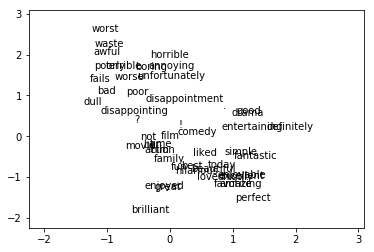

In [14]:
# Examine the Embedding
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')
print("type:",type(embedding_matrix))
print("shape:",embedding_matrix.shape)
print("size:",np.size(embedding_matrix))
print("embedding_matrix:",embedding_matrix)

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])
  #print("embedding_xy[0]:",embedding_xy[0])
  #print("embedding_xy[1]:",embedding_xy[1])
  #print("informative_terms[term_index]:",informative_terms[term_index])


# Do a little setup to make sure the plot displays nicely.
print("embedding_xy[0]:",embedding_xy[0])
print("embedding_xy[1]:",embedding_xy[1])
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 
#term_vector = np.zeros(len(informative_terms))
#print("term_vector : \n",term_vector )
#print("term_vector_shape:",term_vector.shape)

In [15]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

In [16]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
print("informative_terms shape:",np.size(informative_terms))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

informative_terms shape: 30711
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=string>}
 labels: Tensor("IteratorGetNext:1", shape=(?, 1), dtype=float32, device=/device:CPU:0)
 {terms:terms}: {'terms': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=(?,) dtype=string>}
 labels: Tensor("ParseSingleExample/ParseSingleExample:3", shape=(1,), dtype=float32, device=/device:CPU:0)
type of terms : <class 'tensorflow.python.framework.ops.Tensor'>
type of labels: <class 'tensorflow.python.framework.ops.Tensor'>
tf.print labels:------
tf.print------labels-
 features: {'terms': <tf.

In [17]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

import numpy as np
np.set_printoptions(threshold=np.inf)
print(embedding_matrix.shape)
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(30711, 2)


(30711, 2)